In [2]:
#Readme
#step1: Mount Google Drive & Install Environments
#step2: Import libraries necessary for image detection and processing
#step3: define constants
#step4: preprocessing images
#step5: Load and split datasets
#step6: Compute class weights to handle class imbalance
#step7: Data Augmentation
#step8: parameter definition
#step9: Train the model and optimize the efficiency
#step10:
#step11:
#step
#step
#step
#step

In [ ]:
#STEP:1 mount google drive for image import
from google.colab import drive
drive.mount('/content/drive')

In [15]:
#STEP:2 import libraries necessary for image detection and processing
import tensorflow as tf
from tensorflow.keras.models import Model  #for building and training neural network
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import cv2  #for image processing
import numpy as np  #for number manipulation
import shutil  #to export on google drive
import os  #for file system operations
from sklearn.model_selection import train_test_split  #for splitting data
from sklearn.utils import class_weight # for computing class weights

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
#STEP:3 define constants
#dataset_dir = '/content/drive/MyDrive/crackdetection' #if dta on google drive
dataset_dir = '/content/drive/MyDrive/crackdetection'
cracked_dir = os.path.join(dataset_dir, 'cracked')
uncracked_dir = os.path.join(dataset_dir, 'uncracked')

IMG_SIZE = (200, 200)   #image size-resized to this size
BATCH_SIZE = 20     #number of images processed per batch
EPOCHS = 50        #max no of training iterations
SEED = 42    #random seed for reproducibility??

In [ ]:
#STEP:4 preprocessing images                #same for all image detection models
def preprocess_image(image):
    image = cv2.resize(image, IMG_SIZE)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image / 255.0     #normalizing pixel values to [0,1]??
    image = image * 2.0 - 1.0  # [-1, 1] normalization
    return image

In [21]:
#STEP:5 Load and split datasets
def load_dataset():
    images = []
    labels = []
    for folder, label in [(cracked_dir, 1), (uncracked_dir, 0)]:
        for filename in os.listdir(folder):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(folder, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = preprocess_image(img)
                    images.append(img)
                    labels.append(label)
    return np.array(images), np.array(labels)

images, labels = load_dataset()
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=SEED)

Class weights: {0: np.float64(1.0196078431372548), 1: np.float64(0.9811320754716981)}
Train labels: [102 106]
Val labels:   [28 24]
cracked_dir: /content/drive/MyDrive/crackdetection/cracked -> 130
uncracked_dir: /content/drive/MyDrive/crackdetection/uncracked -> 130
sample for model training:


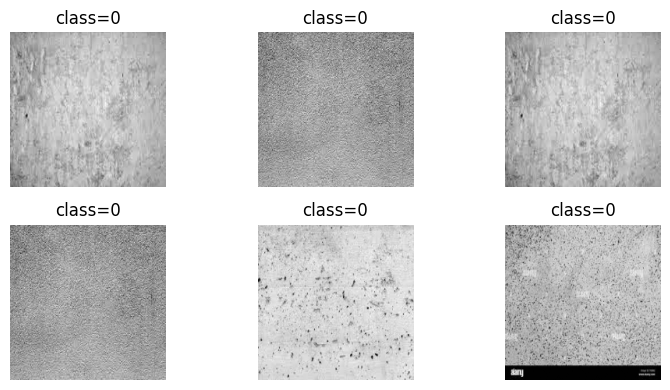

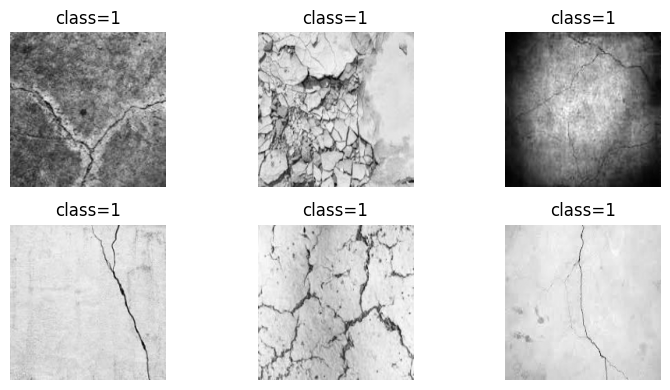

In [22]:
#STEP:6
# Compute class weights to handle class imbalance
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# Optional: Print class weights to see the balance
print("Class weights:", class_weights)

# 4.1 Label distribution
import numpy as np, os
print("Train labels:", np.bincount(y_train.astype(int)))
print("Val labels:  ", np.bincount(y_val.astype(int)))

# 4.2 Count files in folders (sanity)
def count_images(p):
    return sum(f.lower().endswith(('.jpg','.jpeg','.png')) for f in os.listdir(p))
print("cracked_dir:", cracked_dir, "->", count_images(cracked_dir))
print("uncracked_dir:", uncracked_dir, "->", count_images(uncracked_dir))

# 10.3 Visual spot-check: a few samples per class from the *validation* set
import matplotlib.pyplot as plt
def show_samples(X, y, cls, k=6):
    idx = np.where(y==cls)[0][:k]
    plt.figure(figsize=(8,4))
    for i, j in enumerate(idx):
        plt.subplot(2, (k+1)//2, i+1)
        plt.imshow(X[j].squeeze(), cmap='gray')
        plt.title(f"class={cls}")
        plt.axis('off')
    plt.tight_layout(); plt.show()
print("sample for model training:")
show_samples(X_val, y_val, cls=0)  # uncracked
show_samples(X_val, y_val, cls=1)  # cracked

In [23]:
#STEP:7   Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.1,
    height_shift_range=0.1
)
val_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(np.expand_dims(X_train, axis=-1), y_train, batch_size=BATCH_SIZE)
val_generator = val_datagen.flow(np.expand_dims(X_val, axis=-1), y_val, batch_size=BATCH_SIZE)

In [24]:
#STEP:8  parameter definition
def create_standard_cnn():
    inputs = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1))

    # Layer 1
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Layer 2
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Layer 3
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Layer 4
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Dense layers
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    # Create and compile model
    model = Model(inputs=inputs, outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Create model instance
model = create_standard_cnn()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200, 200, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 200, 200, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 200, 200, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 100, 100, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 100, 100, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,465,857 (9.41 MB)

 Trainable params: 2,465,377 (9.40 MB)

 Non-trainable params: 480 (1.88 KB)

In [25]:
#STEP:9  Train the model and optimize the efficiency

# Check dataset size first
print(f"Training images: {len(X_train)}")
print(f"Validation images: {len(X_val)}")
print(f"Training batches per epoch: {len(X_train) // BATCH_SIZE}")

# Enhanced callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Increased patience for small datasets
    restore_best_weights=True,
    verbose=1
)

# Use .keras format (recommended over .h5)
checkpoint = ModelCheckpoint(
    'best_cnn_crack_model.keras',  # Updated format
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Reduce learning rate when stuck
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Train with enhanced monitoring
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint, reduce_lr],
    class_weight=class_weights,
    verbose=1
)

# Print training summary
print(f"Training completed. Best validation loss: {min(history.history['val_loss']):.4f}")
print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")

Training images: 208
Validation images: 52
Training batches per epoch: 10
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5991 - loss: 1.9078
Epoch 1: val_loss improved from inf to 0.65838, saving model to best_cnn_crack_model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6032 - loss: 1.9262 - val_accuracy: 0.4808 - val_loss: 0.6584 - learning_rate: 0.0010
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6975 - loss: 1.7185
Epoch 2: val_loss did not improve from 0.65838
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7003 - loss: 1.7287 - val_accuracy: 0.5385 - val_loss: 0.7054 - learning_rate: 0.0010
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7622 - loss: 1.4819
Epoch 3: val_loss did not improve from 0.65838
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7628 - loss: 1.4808 - val_accuracy: 0.5769 - val_loss: 0.9502 - learning_rate: 0.0010
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8257 - loss: 1.3515
Epoch 4: val_loss did not improve from 0.65838
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s

In [26]:
#STEP:10
# Quantize and convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.int8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
def representative_dataset():
    for _ in range(100):
        data, _ = next(train_generator)
        yield [data.astype(np.float32)]

converter.representative_dataset = representative_dataset
tflite_model = converter.convert()

Saved artifact at '/tmp/tmptnw45scz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 200, 200, 1), dtype=tf.float32, name='keras_tensor_19')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137074204642384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137074204642768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137074204645456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137074204645648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137074204639888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137074204644112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137074204646032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137074204645840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137074204645264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137074204646992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13707420464

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [27]:
#STEP:10
# Save (your model already has the best weights restored)
model.save('/content/drive/MyDrive/best_cnn_crack_model.keras') # Save in .keras format

# Convert to TF.js (reduces file size with 8‑bit weight quantization)
!pip install -q tensorflowjs
!tensorflowjs_converter \
  --input_format=keras \
  --output_format=tfjs_layers_model \
  --quantization_bytes=1 \
  /content/drive/MyDrive/best_cnn_crack_model.keras \
  /content/drive/MyDrive/crack_model_tfjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 680.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
xarray 2025.8.0 requires packaging>=24.1, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.35.1 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
2025-08-23 06:36:39.800079: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755930999.838716    3345 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already be

In [28]:
#STEP 10: Convert Trained Model to TensorFlow.js

print("Converting model to TensorFlow.js format...")

# Create output directory
output_dir = 'crack_detection_tfjs_model'
os.makedirs(output_dir, exist_ok=True)

# Convert Keras model to TensorFlow.js (basic conversion)
tfjs.converters.save_keras_model(model, output_dir)

print(f"✅ Model converted successfully to: {output_dir}/")
print(f"📄 Model file: {output_dir}/model.json")
print(f"⚖️  Weight files: {output_dir}/group*.bin")

Converting model to TensorFlow.js format...


NameError: name 'tfjs' is not defined

In [ ]:
let model;
const MODEL_PATH = 'crack_detection_tfjs_model/model.json';

async function loadModel() {
  model = await tf.loadLayersModel(MODEL_PATH);
  console.log("Model loaded");
}

async function predictImage(file) {
  const img = new Image();
  const reader = new FileReader();

  reader.onload = function () {
    img.src = reader.result;
    img.onload = async function () {
      // Preprocess the image
      const tensor = tf.browser
        .fromPixels(img, 1) // grayscale
        .resizeNearestNeighbor([200, 200])
        .toFloat()
        .div(127.5)
        .sub(1)
        .expandDims(0); // shape: [1, 200, 200, 1]

      // Predict
      const prediction = model.predict(tensor);
      prediction.array().then(scores => {
        const result = scores[0][0] > 0.5 ? "Crack Detected" : "No Crack";
        document.getElementById("result").innerText = result;
      });
    };
  };

  reader.readAsDataURL(file);
}

document.getElementById("imageUpload").addEventListener("change", function (event) {
  const file = event.target.files[0];
  if (file) {
    predictImage(file);
  }
});

// Load model on startup
loadModel();


Train labels: [102 106]
Val labels:   [28 24]
cracked_dir: /content/drive/MyDrive/crackdetection/cracked -> 130
uncracked_dir: /content/drive/MyDrive/crackdetection/uncracked -> 130
sample for model training:


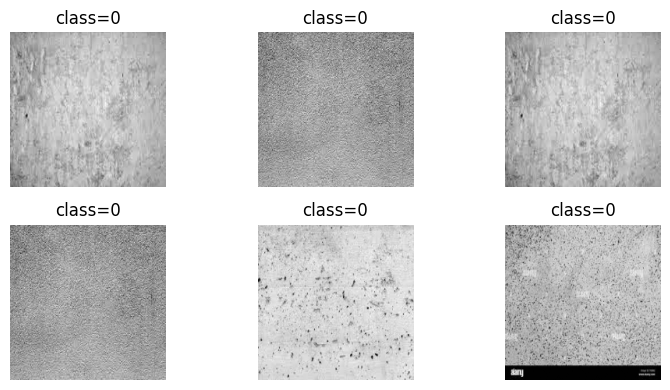

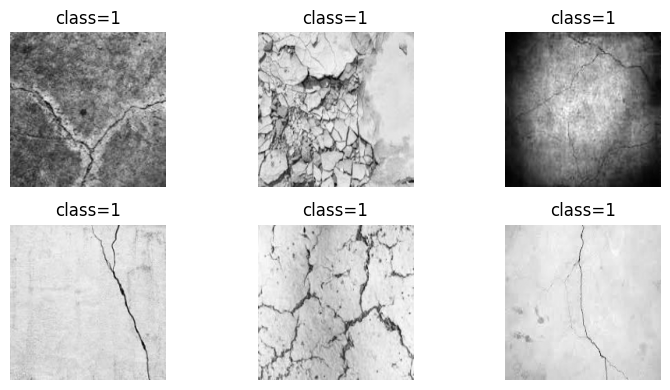

In [29]:
# 4.1 Label distribution
import numpy as np, os
print("Train labels:", np.bincount(y_train.astype(int)))
print("Val labels:  ", np.bincount(y_val.astype(int)))

# 4.2 Count files in folders (sanity)
def count_images(p):
    return sum(f.lower().endswith(('.jpg','.jpeg','.png')) for f in os.listdir(p))
print("cracked_dir:", cracked_dir, "->", count_images(cracked_dir))
print("uncracked_dir:", uncracked_dir, "->", count_images(uncracked_dir))

# 10.3 Visual spot-check: a few samples per class from the *validation* set
import matplotlib.pyplot as plt
def show_samples(X, y, cls, k=6):
    idx = np.where(y==cls)[0][:k]
    plt.figure(figsize=(8,4))
    for i, j in enumerate(idx):
        plt.subplot(2, (k+1)//2, i+1)
        plt.imshow(X[j].squeeze(), cmap='gray')
        plt.title(f"class={cls}")
        plt.axis('off')
    plt.tight_layout(); plt.show()
print("sample for model training:")
show_samples(X_val, y_val, cls=0)  # uncracked
show_samples(X_val, y_val, cls=1)  # cracked